In [3]:
#setting for resizing all to uniform size and reducing memory utilization
img_height=100
img_width=100

In [4]:
import sys
import numpy as np
import pandas as pd
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, Activation, Input, concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
   

from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout
from PIL import Image
import gc


import sys
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from PIL import Image

#from mods_folder import ops as utils_ops

import json

import tensorflow
tensorflow.__version__

'2.5.0'

- Setting path for folders

In [5]:
path1='data\\Car Images-20210501T094840Z-001\\Car Images\\Train Images'
path2='data\\Car Images-20210501T094840Z-001\\Car Images\\Test Images'
path3='data\\Annotations-20210510T185520Z-001\\Annotations'
# fetching all directories list

dirList=next(os.walk(path1))[1]
dirList.sort()
dirList

['AM General Hummer SUV 2000',
 'Acura Integra Type R 2001',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi A5 Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi S4 Sedan 2007',
 'Audi S4 Sedan 2012',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S6 Sedan 2011',
 'Audi TT Hatchback 2011',
 'Audi TT RS Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi V8 Sedan 1994',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3 SUV 2012',
 'BMW X5 SUV 2007',
 'BMW X6

In [6]:
# capturing details of subdirectories of desired folder
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

In [7]:
cat_Folder_list=get_immediate_subdirectories(path1)
cat_Folder_list2=get_immediate_subdirectories(path2)

In [8]:
# get file and folder details and move those details to a data frame for further use

def getFileDetails_df(path,folderList):
    totalImg=0
    df_overview=pd.DataFrame(columns=['Car Details','No of Images'])
    df_FileDetails=pd.DataFrame(columns=['file_name','fol_details','path'])
    for img in folderList:
        c1=len(os.listdir(os.path.join(path, img)))
        df_overview=df_overview.append({'Car Details': img ,'No of Images' : c1},ignore_index=True)
        for filename in os.listdir(os.path.join(path, img)):
            df_FileDetails=df_FileDetails.append({'file_name':filename,
                                                  'fol_details':img,
                                                  'path':os.path.join(path, img,filename)
                                                 },ignore_index=True)
        #print('{}   -->   {} training images'.format(img, len(os.listdir(os.path.join(path1, img)))))
        totalImg+=c1

    print('Total Images:',totalImg)  
    return df_overview,df_FileDetails
    


In [9]:
df_overviewTest, df_testFiles=getFileDetails_df(path2,cat_Folder_list2)
df_overviewTrain, df_trainFiles=getFileDetails_df(path1,cat_Folder_list)

Total Images: 8041
Total Images: 8144


- Tota test images are  - 8041
- Total train images are  - 8144

###### Viewsing number of samples in train and test folders

In [10]:
df_overviewTest.sample(5)

Car Details No of Images
38                    BMW M5 Sedan 2010           41
58          Chevrolet Corvette ZR1 2012           46
138     Hyundai Veloster Hatchback 2012           41
116           Ford Ranger SuperCab 2011           42
156  Maybach Landaulet Convertible 2012           29

In [11]:
df_overviewTrain.sample(5)

Car Details No of Images
159  Mercedes-Benz 300-Class Convertible 1993           48
59           Chevrolet Express Cargo Van 2007           30
28          Bentley Continental GT Coupe 2012           35
16                         Audi S4 Sedan 2007           45
39                    BMW M6 Convertible 2010           41

In [12]:
df_overviewTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Car Details   196 non-null    object
 1   No of Images  196 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB


In [13]:
max(df_overviewTrain['No of Images'])

68

In [14]:
max(df_overviewTest['No of Images'])

68

In [15]:
df_overviewTrain['No of Images'].value_counts()

44    27
43    26
45    24
42    22
41    20
39    15
40    12
46    10
38     7
37     6
36     5
34     4
33     3
35     3
48     2
47     2
31     1
30     1
49     1
68     1
24     1
28     1
29     1
32     1
Name: No of Images, dtype: int64

In [16]:
df_overviewTest['No of Images'].value_counts()

42    32
44    26
43    24
41    19
45    14
40    14
39    13
38    11
46     8
36     7
35     5
37     5
33     3
34     3
32     3
29     2
48     2
47     1
68     1
24     1
27     1
30     1
Name: No of Images, dtype: int64

In [17]:
df_overviewTrain.loc[df_overviewTrain['No of Images']==68]

Car Details No of Images
120  GMC Savana Van 2012           68

In [18]:
df_overviewTrain.loc[df_overviewTrain['No of Images']==24]

Car Details No of Images
129  Hyundai Accent Sedan 2012           24

In [19]:
df_overviewTest.loc[df_overviewTest['No of Images']==68]

Car Details No of Images
120  GMC Savana Van 2012           68

In [20]:
df_overviewTest.loc[df_overviewTest['No of Images']==24]

Car Details No of Images
129  Hyundai Accent Sedan 2012           24

<AxesSubplot:xlabel='No of Images'>

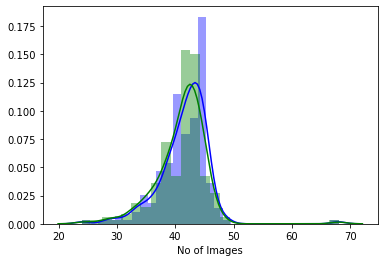

In [21]:
sns.distplot(df_overviewTrain['No of Images'],color='b')
sns.distplot(df_overviewTest['No of Images'],color='g')

- We have a wide distribution of car images across the folders
- Min number of images in a folder is 24 and maximum 68, similar pattern is visible in train and test directories
- distribution are similar for train and test images

###### Putting together annotations

In [22]:
df_annotations_train = pd.read_csv(os.path.join(path3, 'Train Annotations.csv'))
df_annotations_test  = pd.read_csv(os.path.join(path3, 'Test Annotation.csv'))

In [23]:
cols=['file_name','x1','y1','x2','y2','class_Id']
df_annotations_train.columns=cols
df_annotations_test.columns=cols

In [24]:
df_annotations_train.sample(5)

file_name  x1   y1   x2   y2  class_Id
5395  05396.jpg  26   91  615  411        50
33    00034.jpg  37   63  614  397       133
4291  04292.jpg  33   72  540  322        11
350   00351.jpg  13  108  454  305        42
6848  06849.jpg  14   41  463  322        48

In [25]:
df_annotations_test.sample(5)

file_name   x1   y1   x2   y2  class_Id
2257  02258.jpg   82  105  418  280        19
1116  01117.jpg   45   39  729  414         1
1994  01995.jpg  133   72  892  690       153
755   00756.jpg   66   44  906  636       147
6586  06587.jpg    8   36  496  328        84

###### Merging image annotations with details

In [26]:
df_train = pd.merge(df_trainFiles,df_annotations_train,on='file_name')
df_test  = pd.merge(df_testFiles,df_annotations_test,on='file_name')

In [27]:
df_train.head(5)

file_name                fol_details  \
0  00198.jpg  Acura Integra Type R 2001   
1  00255.jpg  Acura Integra Type R 2001   
2  00308.jpg  Acura Integra Type R 2001   
3  00374.jpg  Acura Integra Type R 2001   
4  00878.jpg  Acura Integra Type R 2001   

                                                path   x1   y1   x2   y2  \
0  data\Car Images-20210501T094840Z-001\Car Image...   91  121  574  357   
1  data\Car Images-20210501T094840Z-001\Car Image...   29   78  734  396   
2  data\Car Images-20210501T094840Z-001\Car Image...   16  136  775  418   
3  data\Car Images-20210501T094840Z-001\Car Image...    9  184  740  499   
4  data\Car Images-20210501T094840Z-001\Car Image...  101  162  882  650   

   class_Id  
0         6  
1         6  
2         6  
3         6  
4         6

In [28]:
df_test.head(5)

file_name                fol_details  \
0  00128.jpg  Acura Integra Type R 2001   
1  00130.jpg  Acura Integra Type R 2001   
2  00386.jpg  Acura Integra Type R 2001   
3  00565.jpg  Acura Integra Type R 2001   
4  00711.jpg  Acura Integra Type R 2001   

                                                path   x1   y1   x2   y2  \
0  data\Car Images-20210501T094840Z-001\Car Image...  122  149  743  455   
1  data\Car Images-20210501T094840Z-001\Car Image...   27   74  774  449   
2  data\Car Images-20210501T094840Z-001\Car Image...   86  184  723  425   
3  data\Car Images-20210501T094840Z-001\Car Image...   15    1  545  347   
4  data\Car Images-20210501T094840Z-001\Car Image...  126   65  735  347   

   class_Id  
0         6  
1         6  
2         6  
3         6  
4         6

In [29]:
df_train.path[0]

'data\\Car Images-20210501T094840Z-001\\Car Images\\Train Images\\Acura Integra Type R 2001\\00198.jpg'

In [36]:
# for training
carType = ''
SubCounter = 0
with open("annotationAlt_subset_20im.txt", "w+") as f:
    for idx, row in df_train.iterrows():
        
        if(SubCounter>=20):
            if(carType == row['fol_details']):
                SubCounter+=1
                continue
            else:
                SubCounter=0 
                
        #img = cv2.imread('train/' + row['FileName'])
        #height, width = img.shape[:2]
        x1 = int(row['x1'] )
        x2 = int(row['x2'] )
        y1 = int(row['y1'] )
        y2 = int(row['y2'] )
      
        #google_colab_file_path = 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/train'
        #fileName = os.path.join(google_colab_file_path, row['FileName'])
        fileName = row['path']
        #className = row['class_Id']
        className = 'Car'
                
        carType=row['fol_details']
        SubCounter+=1
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + str(className) + '\n')

In [31]:
# for test
carType = ''
SubCounter = 0
with open("test_annotationAlt_subset.txt", "w+") as f:
    for idx, row in df_test.iterrows():
        
        if(SubCounter>=2):
            if(carType == row['fol_details']):
                SubCounter+=1
                continue
            else:
                SubCounter=0            
            
            
            
        
        #img = cv2.imread('train/' + row['FileName'])
        #height, width = img.shape[:2]
        x1 = int(row['x1'] )
        x2 = int(row['x2'] )
        y1 = int(row['y1'] )
        y2 = int(row['y2'] )
      
        #google_colab_file_path = 'drive/My Drive/AI/Dataset/Open Images Dataset v4 (Bounding Boxes)/train'
        #fileName = os.path.join(google_colab_file_path, row['FileName'])
        fileName = row['path']
        
        #className = row['class_Id']
        className = 'Car'
        carType=row['fol_details']
        SubCounter+=1
            
        f.write(fileName + ',' + str(x1) + ',' + str(y1) + ',' + str(x2) + ',' + str(y2) + ',' + str(className) + '\n')